# Principal Component Analysis As A Factor Model

## Introduction
...**To Do**

Import packages

In [1]:
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt

Magic

In [2]:
%matplotlib inline

## Data Collection

Pull S&P 500 Index constituents' OHLCV data

In [3]:
with open('sp500_data.pickle', 'rb') as f:
    data = pickle.load(f)
    
f.close()

Inspect SP 500 OHLCV data

In [4]:
data.head()

Attributes     open                                                       \
Symbols           A      AAL       AAP     AAPL     ABBV      ABC   ABMD   
date                                                                       
2014-06-11  39.7249  40.8679  125.4561  86.2724  44.7610  66.3854  22.97   
2014-06-12  40.1131  39.3151  124.7323  86.1899  45.0686  66.3023  22.84   
2014-06-13  39.8612  38.3434  123.5920  84.5035  44.6114  65.9883  23.16   
2014-06-16  39.8884  37.8004  123.3638  83.8711  45.0353  66.1360  23.02   
2014-06-17  39.6841  39.1341  124.0086  84.6043  45.2930  65.9144  23.24   

Attributes                            ...        close                    \
Symbols         ABT      ACN   ADBE   ...          ZBH     ZION      ZTS   
date                                  ...                                  
2014-06-11  36.1791  75.3425  66.90   ...     101.5068  28.0164  30.9798   
2014-06-12  35.9453  75.0623  67.23   ...     101.0367  27.7535  30.8448   
2014-06-13  35.7565  74.9899  66.70   ...     101.2861  27.8192  30.9702   
2014-06-16  35.8105  74.5199  66.80   ...     100.7105  27.4060  30.9798   
2014-06-17  35.7835  74.6916  67.36   ...     100.4707  27.9601  31.6355   

Attributes   volume                                                        
Symbols        XRAY      XRX      XYL      YUM      ZBH     ZION      ZTS  
date                                                                       
2014-06-11   708769  1211994   759873  1479438   622134  1065018  3600715  
2014-06-12  1086067  1469251  2333384  1937628  1447976  2212227  4298497  
2014-06-13   777116  1289961  1301387  1727884   796011  1619559  1904472  
2014-06-16  1553933  1068451   869797  1387268  1286570  1328835  2197198  
2014-06-17   602148  1571559   678583  1383771  1075786  2694217  4407376  

[5 rows x 2525 columns]

In [5]:
data.tail()

Attributes   open                                                              \
Symbols         A    AAL     AAP    AAPL   ABBV    ABC    ABMD    ABT     ACN   
date                                                                            
2019-06-04  67.66  27.63  154.56  175.44  76.14  81.29  264.11  76.25  177.27   
2019-06-05  68.61  29.76  155.26  184.28  77.41  82.86  270.00  77.84  179.42   
2019-06-06  68.52  30.40  154.64  183.08  77.16  81.55  268.48  78.85  180.00   
2019-06-07  69.70  30.59  155.10  186.51  77.49  82.33  270.29  80.49  181.63   
2019-06-10  69.68  31.15  156.36  191.81  77.46  83.63  269.61  81.00  184.33   

Attributes           ...      close                  volume                    \
Symbols       ADBE   ...        ZBH   ZION     ZTS     XRAY      XRX      XYL   
date                 ...                                                        
2019-06-04  263.27   ...     117.41  44.40  108.12  3158244  3416198   898962   
2019-06-05  272.78   ...     118.54  44.18  108.50  1626233  1859347  1014755   
2019-06-06  273.72   ...     120.31  44.24  108.89  1445450  2033525   740818   
2019-06-07  275.87   ...     120.73  43.64  110.06   944683  1537903   606412   
2019-06-10  280.98   ...     121.71  43.84  110.22  1301536  1310152   358630   

Attributes                                      
Symbols         YUM      ZBH     ZION      ZTS  
date                                            
2019-06-04  2501697  1091204  2669285  3712082  
2019-06-05  1356243  1242855  1886726  3224165  
2019-06-06  1598313  1201870  1898158  3123425  
2019-06-07  1318211   758934  2360379  1964788  
2019-06-10  1159492   711541  1866280  2730091  

[5 rows x 2525 columns]

In [6]:
data.describe()

Attributes         open                                                      \
Symbols               A          AAL          AAP         AAPL         ABBV   
count       1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean          52.003140    41.234970   145.446171   135.052102    66.639468   
std           13.878884     6.374282    24.152180    38.092691    17.744580   
min           32.074900    25.365300    78.989200    82.679600    43.060100   
25%           39.414800    36.538525   132.584350   103.656150    53.032275   
50%           46.016200    40.867550   150.309900   119.434250    58.457300   
75%           65.610300    46.224650   162.128625   168.023225    82.712300   
max           81.880000    57.901700   200.014700   228.116900   114.829200   

Attributes                                                                   \
Symbols             ABC         ABMD          ABT          ACN         ADBE   
count       1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean          84.542149   162.659841    49.086368   118.378938   142.175856   
std            9.512240   116.721290    12.636365    31.175865    70.417212   
min           65.813300    22.230000    33.777000    67.981900    59.610000   
25%           77.557000    80.552500    39.372025    92.581150    82.022500   
50%           83.854550   118.650000    43.038850   112.077750   107.995000   
75%           89.977950   260.662500    58.140700   149.530850   211.320000   
max          109.430200   452.900000    81.000000   184.330000   291.000000   

Attributes      ...             close                                  volume  \
Symbols         ...               ZBH         ZION          ZTS          XRAY   
count           ...       1258.000000  1258.000000  1258.000000  1.258000e+03   
mean            ...        111.697803    36.704361    59.798250  1.632538e+06   
std             ...          9.929764    10.736900    20.223068  1.313762e+06   
min             ...         89.236100    18.885300    30.652000  2.412020e+05   
25%             ...        103.343675    26.826025    44.749325  8.979605e+05   
50%             ...        112.761500    38.198900    51.333600  1.349956e+06   
75%             ...        119.131625    46.431025    80.809150  2.031814e+06   
max             ...        130.912800    57.139500   110.220000  2.326882e+07   

Attributes                                                          \
Symbols              XRX           XYL           YUM           ZBH   
count       1.258000e+03  1.258000e+03  1.258000e+03  1.258000e+03   
mean        2.464691e+06  1.122086e+06  2.887372e+06  1.301264e+06   
std         1.468039e+06  5.002000e+05  2.104376e+06  7.043626e+05   
min         4.119940e+05  1.958830e+05  6.667050e+05  2.334500e+05   
25%         1.575638e+06  7.606355e+05  1.722924e+06  8.967002e+05   
50%         2.128740e+06  1.024334e+06  2.331002e+06  1.145786e+06   
75%         2.940192e+06  1.368052e+06  3.353706e+06  1.498612e+06   
max         1.796426e+07  5.043272e+06  3.679555e+07  1.007729e+07   

Attributes                              
Symbols             ZION           ZTS  
count       1.258000e+03  1.258000e+03  
mean        2.678522e+06  3.103167e+06  
std         1.301667e+06  1.753438e+06  
min         6.518150e+05  7.104990e+05  
25%         1.864085e+06  2.055604e+06  
50%         2.389688e+06  2.664477e+06  
75%         3.141944e+06  3.617988e+06  
max         1.509174e+07  2.141490e+07  

[8 rows x 2525 columns]

In [7]:
data.shape

(1258, 2525)

Close prices data

In [8]:
close = data.close

Inspect

In [9]:
close.head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-06-11,40.1199,40.2868,125.0694,86.0249,45.0769,66.4223,22.92,35.9633,74.9719,67.46,...,25.6691,40.9150,84.1321,46.6073,28.8084,35.4555,51.7899,101.5068,28.0164,30.9798
2014-06-12,39.7726,38.2958,123.2252,84.5860,44.6031,65.9975,23.03,35.7925,74.5018,66.56,...,25.8547,41.1019,83.8928,46.4230,28.5372,35.2780,51.2950,101.0367,27.7535,30.8448
2014-06-13,39.8407,38.4672,123.7407,83.6603,45.0187,66.2930,22.95,35.7745,74.7820,66.82,...,25.8884,41.6091,84.7098,46.3744,28.4920,36.0532,51.5945,101.2861,27.8192,30.9702
2014-06-16,39.7181,39.1150,124.0086,84.5035,44.8857,66.0529,23.27,35.8734,74.8634,67.62,...,26.0740,41.9028,84.9326,46.4424,28.3791,35.9318,51.5099,100.7105,27.4060,30.9798
2014-06-17,40.0927,39.8867,124.9411,84.3935,45.1351,66.2561,23.43,35.8375,74.5832,67.54,...,26.0910,42.2409,84.5200,46.2677,28.8310,36.0346,51.7639,100.4707,27.9601,31.6355


In [10]:
close.tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-04,67.95,29.12,154.61,179.64,76.75,82.21,267.06,77.46,177.97,268.71,...,57.78,106.90,73.59,54.40,33.30,77.40,106.97,117.41,44.40,108.12
2019-06-05,68.35,30.36,154.61,182.54,77.06,81.65,268.80,78.69,179.56,272.86,...,59.32,105.60,72.98,55.38,33.42,78.88,107.29,118.54,44.18,108.50
2019-06-06,69.16,30.38,154.90,185.22,77.07,81.75,269.19,80.09,180.40,274.80,...,59.80,106.01,74.31,55.63,34.03,79.15,108.42,120.31,44.24,108.89
2019-06-07,69.52,30.92,155.35,190.15,77.43,83.48,267.87,80.74,182.92,278.16,...,59.43,107.49,74.58,55.94,34.16,79.56,109.07,120.73,43.64,110.06
2019-06-10,70.29,30.76,153.52,192.58,76.95,84.77,272.43,81.27,184.44,280.34,...,59.26,110.88,74.91,57.10,34.69,80.38,108.65,121.71,43.84,110.22


In [11]:
# close.fillna(method='bfill', inplace=True)

Calculate daily returns

In [12]:
returns = close.pct_change()

In [13]:
returns.head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-12,-0.008657,-0.049421,-0.014745,-0.016727,-0.010511,-0.006395,0.004799,-0.004749,-0.006270,-0.013341,...,0.007230,0.004568,-0.002844,-0.003954,-0.009414,-0.005006,-0.009556,-0.004631,-0.009384,-0.004358
2014-06-13,0.001712,0.004476,0.004183,-0.010944,0.009318,0.004477,-0.003474,-0.000503,0.003761,0.003906,...,0.001303,0.012340,0.009739,-0.001047,-0.001584,0.021974,0.005839,0.002468,0.002367,0.004066
2014-06-16,-0.003077,0.016840,0.002165,0.010079,-0.002954,-0.003622,0.013943,0.002765,0.001088,0.011972,...,0.007169,0.007059,0.002630,0.001466,-0.003963,-0.003367,-0.001640,-0.005683,-0.014853,0.000310
2014-06-17,0.009431,0.019729,0.007520,-0.001302,0.005556,0.003076,0.006876,-0.001001,-0.003743,-0.001183,...,0.000652,0.008069,-0.004858,-0.003762,0.015924,0.002861,0.004931,-0.002381,0.020218,0.021165


In [14]:
returns.tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-04,0.014330,0.070588,0.009401,0.036584,0.013871,0.022894,0.021535,0.023115,0.016042,0.037370,...,-0.002934,0.044966,0.023790,0.010026,0.074887,0.022187,0.027471,0.027209,0.024931,0.040115
2019-06-05,0.005887,0.042582,0.000000,0.016143,0.004039,-0.006812,0.006515,0.015879,0.008934,0.015444,...,0.026653,-0.012161,-0.008289,0.018015,0.003604,0.019121,0.002991,0.009624,-0.004955,0.003515
2019-06-06,0.011851,0.000659,0.001876,0.014682,0.000130,0.001225,0.001451,0.017791,0.004678,0.007110,...,0.008092,0.003883,0.018224,0.004514,0.018253,0.003423,0.010532,0.014932,0.001358,0.003594
2019-06-07,0.005205,0.017775,0.002905,0.026617,0.004671,0.021162,-0.004904,0.008116,0.013969,0.012227,...,-0.006187,0.013961,0.003633,0.005573,0.003820,0.005180,0.005995,0.003491,-0.013562,0.010745
2019-06-10,0.011076,-0.005175,-0.011780,0.012779,-0.006199,0.015453,0.017023,0.006564,0.008310,0.007837,...,-0.002861,0.031538,0.004425,0.020737,0.015515,0.010307,-0.003851,0.008117,0.004583,0.001454


In [15]:
returns.shape

(1258, 505)

## Momentum Strategy Implementation
1. PCA
2. OLS
3. Momentum

...**To Do**

### Set Parameters
...**To Do**

Lookback period

In [16]:
lookback = 250

Number of factors 

In [17]:
number_of_factors = 5

Top n stocks

In [18]:
top_n = 50

### Principal Component Analysis (PCA)
...**To Do**

### Ordinary Least Squares (OLS)
...**To Do**

### Momentum Strategy
...**To Do**

Initialize positions

In [19]:
positions = pd.DataFrame(np.zeros((returns.shape[0], returns.shape[1])),
                         index=returns.index,
                         columns=returns.columns
                        )

Momentum strategy

In [20]:
len(close)

1258

In [21]:
for i in range(lookback + 1, len(close)):
    
    # Calculate the daily returns
    R = returns.iloc[i - lookback + 1:i, :]

    # Avoid daily returns with NaNs
    has_data = (R.count() == max(R.count()))
    has_data_list = list(R.columns[has_data])
    R = R.loc[:, has_data_list]

    # Calculate the mean of the daily returns
    R_mean = R.mean()

    # Calculate the adjusted daily returns
    R_adj = R.sub(R_mean)
    
    # Calculate the covariance matrix
    cov = R_adj.cov()
    
    # Calculate the eigenvalues (B) and eigenvectors (X)
    eigen = np.linalg.eig(cov)
    B = eigen[0]
    X = eigen[1]
    
    # Retain only a number of factors
    X = X[:, :number_of_factors]
    
    # OLS
    model = sm.OLS(R_adj.iloc[-1], X)
    results = model.fit()
    b = results.params
    
    # Calculate the expected returns
    R_exp = R_mean.add(np.matmul(X, b))
    
    # Momentum strategy
    shorts = R_exp.sort_values()[:top_n].index
    positions.iloc[i][shorts] = -1
    longs = R_exp.sort_values()[-top_n:].index
    positions.iloc[i][longs] = 1
    

In [22]:
shorts

Index(['KHC', 'IVZ', 'BBT', 'HBAN', 'PNC', 'FITB', 'NEM', 'PM', 'CMA', 'MO',
       'MTB', 'SJM', 'GIS', 'RF', 'ED', 'PPL', 'DUK', 'PBCT', 'CFG', 'BK',
       'PFG', 'SO', 'KEY', 'ZION', 'TAP', 'JEF', 'STI', 'WFC', 'K', 'D', 'CPB',
       'AEP', 'VZ', 'USB', 'CB', 'KMB', 'T', 'UNM', 'ATO', 'AIG', 'KO', 'LNT',
       'DTE', 'EVRG', 'STT', 'CBOE', 'PNW', 'CNP', 'CMS', 'NI'],
      dtype='object', name='Symbols')

In [23]:
longs

Index(['MU', 'GOOG', 'MAT', 'GOOGL', 'CNC', 'ALXN', 'PKI', 'IQV', 'NKTR', 'V',
       'AAPL', 'BSX', 'XLNX', 'VRTX', 'TSS', 'MSCI', 'AKAM', 'CDNS', 'SNPS',
       'NTAP', 'VRSN', 'IDXX', 'KEYS', 'FB', 'EA', 'GPN', 'MSFT', 'ANSS', 'MA',
       'ATVI', 'INTU', 'PYPL', 'EW', 'UA', 'ISRG', 'UAA', 'AMZN', 'ILMN',
       'ANET', 'NVDA', 'TTWO', 'ALGN', 'ADBE', 'ADSK', 'FTNT', 'NFLX', 'CRM',
       'ABMD', 'TWTR', 'AMD'],
      dtype='object', name='Symbols')

## Performance Analysis
1. Sharpe Ratio
2. Maximum Drawdown

...**To Do**

Adjust positions

In [24]:
positions = positions.shift(periods=1)

In [25]:
positions.head()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2014-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-06-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
positions.tail()

Symbols,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-06-04,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-05,0.0,0.0,0.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2019-06-06,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-06-10,0.0,-1.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Compute the daily returns of the momentum strategy

In [27]:
returns_strat = (positions.mul(returns)).sum(axis='columns')

Compute the annualized average return of the momentum strategy

In [28]:
returns_strat_avg = returns_strat.mean() * 250

In [29]:
returns_strat_avg

-0.12404414155112715

Plot the cumulative PnL

Text(0.5, 1.0, 'Cumulative PnL Of Momentum Trading Strategy')

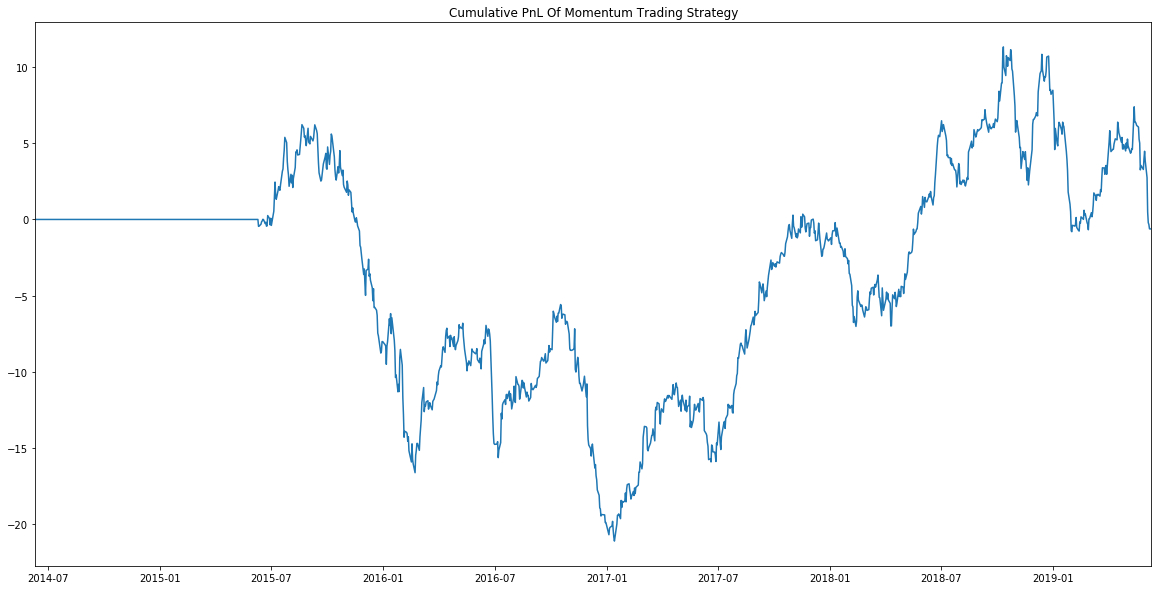

In [30]:
plt.figure(figsize=(20, 10))

plt.plot(returns_strat.cumsum())
plt.xlim(returns_strat.index[0], returns_strat.index[-1])

plt.title('Cumulative PnL Of Momentum Trading Strategy')

## Conclusion
...**To Do**